# Intelligence Artificielle Avancée
## TP5 : Introduction au Deep Learning

Au cas où, il nous faut d'abord vérifier la version du Keras et Tensorflow:

In [86]:
import tensorflow as tf
from tensorflow.python import keras
print("Keras:", keras.__version__)
print("Tensorflow:", tf.__version__)


Keras: 2.6.0
Tensorflow: 2.11.0


**Installer Pydot et Graphiz, si ne sont pas déjà installés:**

Puis vous devez relancer le noyau : trouver 'restart kernel' dans les menus.

## De la documentation


### Deep Learning avec Keras
- Doc keras :https://keras.io/
- Le model Sequential (premier pas) : https://keras.io/getting-started/sequential-model-guide/#getting-started-with-the-keras-sequential-model
- Un framework plus riche : https://keras.io/getting-started/functional-api-guide/

### Autres Toolkits et packages

- Lasagne : Langage *de haut niveau* comme keras


NB : Lasagne et Keras utilisent indifférement un backend parmi Theano (Univ. Montreal) et Tensorflow (Google)

- Theano :  le package de l'Univ. de Montréal

- Tensorflow :  le package Google

- Caffe : très spécialisé images

- Pytorch : la plateforme de Facebook

- ...


## Récupération d'un dataset existant
On va travailler avec un jeux de données historique que vous conaissez déjà : MNIST. Ce sont des chiffres manuscrits, donc des images en niveaux de gris, en résolution 28x28 cette fois (cela peut prendre un peu de temps - et générer un FutureWarning, ce qui n'est pas grave) :

In [87]:
from keras.datasets import mnist
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = mnist.load_data()

dimension des données :  (60000, 28, 28) (60000,)
Une données sous format plus lisible :


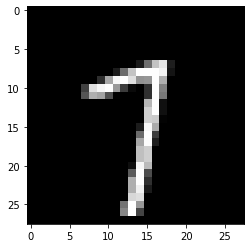

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt

print("dimension des données : ", X_train.shape, y_train.shape)
#print("une données : ")
#print(X_test[42])

print("Une données sous format plus lisible :")
plt.imshow(X_train[42], cmap=plt.get_cmap('gray'))
plt.show()

### Prétraitement
Les données ne sont pas dans le format nécessaire à Keras : il vaut vectoriser chaque image. On va aussi les normaliser, pour n'avoir que des valeurs comprisent entre 0 et 1 (améliore la vitesse de convergence)

In [89]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

import numpy as np
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [90]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print("Classe de la data num 42 :", y_train[42])

(60000, 784)
(10000, 784)
(60000,)
Classe de la data num 42 : 7


#### One-hot-encoding
Les réseaux de neurones ont besoin d'un vecteur à la place de *y* : on utilise un codage où la taille de ce vecteur est le nombre de classe, toutes les valeurs du vecteurs sont égales à 0, sauf celle qui correspond à la bonne classe qui elle vaut 1.

In [91]:
# On transforme les sorties (numéros de classe) en des vecteurs de type one-hot-code
nb_classes = 10

Y_train = y_train
Y_test = y_test
y_train =  np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)


In [92]:
print(y_train.shape)
print("Classe de la data num 42 : ", y_train[42])

(60000, 10)
Classe de la data num 42 :  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## Apprendre un réseau de neurones pour la classification de MNIST
D'abord il faut créer le model.
On ajoute les couches une à une. Ici un modèle qui :
- prend en entrée un vecteur de dimension 784 (une image Mnist 28x28 vectorisée)
- transforme l'entrée en un vecteur de dimension 64 avec une couche totalement connectée (Dense), avec une fonction d'une activation de type Rectified Linear Unit 
- Transforme la sortie de la couche précédente (de dimension 64) en un vecteur de dimension 10 avec une autre couche dense 
- Transforme le vecteur de dimenbsion 10 en un autre vecteur de dimension 10 à l'aide d'une couche dense avec la fonction d'activation softmax

In [93]:
# Import from Keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential


On crée note réseau de neurones (cela génère un warning désagréable mais qui ne pause pas de problème finalement) :

In [94]:
model = Sequential()
model.add(Dense(64, input_dim=784, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))

Puis il faut "compiler" le modèle, en précisant :
- le critère d'optimisation : le *loss*
- la routine d'optimisation (ie l'utilisation du gradient) : l'*optimizer*
- les métriques additionnelles au *loss* (ici l'*accuracy*, le taux de bonne classification) que l'on va calculer à chaque fois

In [95]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

### Affichage de la structure du modèle

Expliquee les différentes éléments de chacune des lignes affichées par la commande suivante.

In [96]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 64)                50240     
                                                                 
 dense_63 (Dense)            (None, 10)                650       
                                                                 
 dense_64 (Dense)            (None, 10)                110       
                                                                 
Total params: 51,000
Trainable params: 51,000
Non-trainable params: 0
_________________________________________________________________


Ou une manière plus graphique (nécessite l'installation de pydot et surtout de graphviz, ce qui n'est pas forcément facile) :

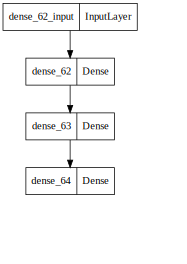

In [97]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### On peut maintenant apprendre le modèle en précisant 
- la base d'apprentissage (les deux premiers paramètres)
- le nombre d'itérations d'apprentissage (*epochs*)
- la taille des minibatchs (*batch_size*)
- un ensemble de validation (soit on utilise comme ici un pourcentage des données d'entrée *X_train, y_train*, soit d'autres ensemble de données via *validation_data=(X_test, y_test)*)
- le niveau de verbosité de l'affichage

*(là encore, on a un WARNING, mais il n'empêche pas le code de fonctionner)*

In [98]:
h = model.fit(X_train, y_train,
              epochs=3,
              batch_size=16,
              verbose =1,
              validation_split=0.33)

Epoch 1/3
2513/2513 [==============================] - 10s 4ms/step - loss: 2.2686 - acc: 0.1351 - val_loss: 2.2404 - val_acc: 0.1542
Epoch 2/3
2513/2513 [==============================] - 9s 4ms/step - loss: 2.2094 - acc: 0.1741 - val_loss: 2.1835 - val_acc: 0.1824
Epoch 3/3
2513/2513 [==============================] - 10s 4ms/step - loss: 2.1540 - acc: 0.1972 - val_loss: 2.1299 - val_acc: 0.2056


### Evaluation
On peut alors évaluer le modèle sur l'ensemble de test

In [99]:
score = model.evaluate(X_test, y_test, verbose=2, batch_size=16)

print (score)

625/625 - 1s - loss: 2.1183 - acc: 0.2170 - 895ms/epoch - 1ms/step
[2.118299722671509, 0.21699999272823334]


### Historique de processus
Les info sur le processus d'apprentissage sont stockées dans *h*.

Comme on va en avoir besoin plusieurs fois, on écrit une fonction qui prend un historique d'apprentissage et affiche les courbes : une pour la fonction de perte (loss) et l'autre pour le taux de réussite (accuracy) :

In [100]:
def affiche_evolution_apprentissage(history):
    #affiche history.history.keys()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('accuracy du modèle')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['données apprentissage', 'données test'], loc='upper left')
    plt.show()
    # résumé de l'historique pour loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss du modèle')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['apprentissage', 'test'], loc='upper left')
    plt.show()

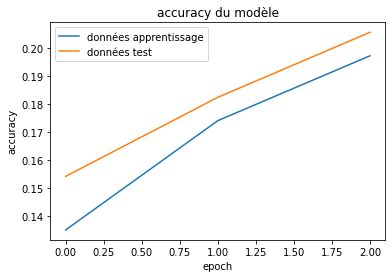

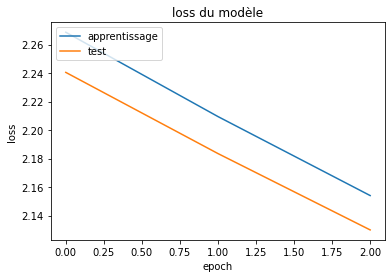

In [101]:
affiche_evolution_apprentissage(h)

#### En utilisant les réseaux de neurones convolutionnels, proposer un deuxième modèle sur la même donnée (MNIST), le modèle proposé sera constité de deux couches (Conv2D de taille 3), après chaque couche de convoltion une couche d'échantillonnage  (MaxPooling2D de taille 2) est fortement recommandée.   

In [102]:
#A vous


from keras.datasets import mnist
from keras.utils import to_categorical

(X_train,y_train),(X_test,y_test) = mnist.load_data()

X_train = X_train.reshape((60000,28,28,1))
X_train = X_train.astype('float32')/255

X_test = X_test.reshape((10000,28,28,1))
X_test = X_test.astype('float32')/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



from keras import layers
from keras import models
model2 = models.Sequential()
model2.add(layers.Conv2D(32,(3,3),activation = 'relu',input_shape =(28,28,1)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(64,(3,3),activation = 'relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(64,activation = 'relu'))
model2.add(layers.Dense(10,activation = 'softmax'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_65 (Dense)            (None, 64)               

#### Evaluer les nouveau model construit (CNN) et le comparer avec le modèle dense (MLP)

In [103]:
#a vous

model2.compile(optimizer = 'adadelta', 
               loss = 'categorical_crossentropy',
               metrics = ['acc'])

h2 = model2.fit(X_train,y_train, epochs = 3, batch_size = 16, 
                verbose = 1, 
                validation_split= 0.33)

score2 = model2.evaluate(X_test,y_test)
print("[loss, accuracy] = ",score2)





Epoch 1/3
2513/2513 [==============================] - 56s 22ms/step - loss: 2.2730 - acc: 0.1556 - val_loss: 2.2385 - val_acc: 0.3038
Epoch 2/3
2513/2513 [==============================] - 53s 21ms/step - loss: 2.2037 - acc: 0.4452 - val_loss: 2.1646 - val_acc: 0.5320
Epoch 3/3
313/313 [==============================] - 4s 13ms/step - loss: 2.0659 - acc: 0.6107
[loss, accuracy] =  [2.065863609313965, 0.6107000112533569]


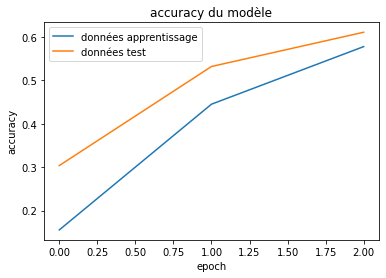

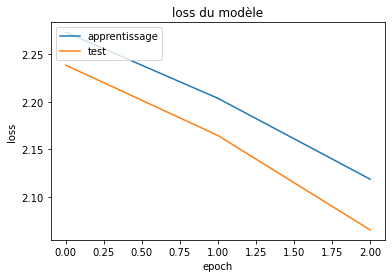

In [104]:
affiche_evolution_apprentissage(h2)

#### Evaluer les hyperparamètres droupout et batch-size sur la perfermance du modèle

In [105]:
#A vous


### Callback
Permet de programmer la sauvegarde des modèles à chaque itération, l'adaptation du pas d'apprentissage (learning rate), une procédure de early stopping, etc.

Voir <https://keras.io/callbacks/> pour les détails

In [106]:
# Early Stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1, mode='auto')

# Adaptation du pas d'apprentissage
from keras.callbacks import ReduceLROnPlateau
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', 
                       min_delta=0.0001, cooldown=0, min_lr=0)


(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

import numpy as np
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


Y_train = y_train
Y_test = y_test
y_train =  np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)


h_es_lr = model.fit(X_train, y_train,
                    epochs=2,
                    batch_size=16,
                    verbose =1,
                    validation_split=0.33,
                    callbacks=[es, lr])

Epoch 1/2
2513/2513 [==============================] - 9s 4ms/step - loss: 2.3008 - acc: 0.2253 - val_loss: 2.3007 - val_acc: 0.2032 - lr: 0.0010
Epoch 2/2
2513/2513 [==============================] - 9s 4ms/step - loss: 2.3006 - acc: 0.1903 - val_loss: 2.3006 - val_acc: 0.1733 - lr: 0.0010


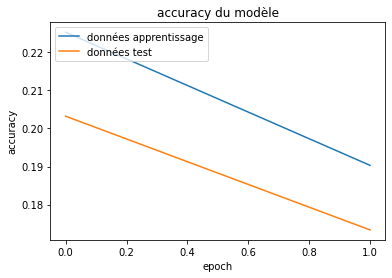

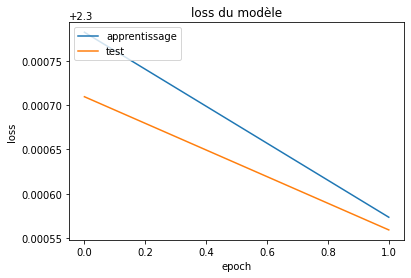

In [107]:
affiche_evolution_apprentissage(h_es_lr)

## Sauver et récupérer des models

In [108]:
from keras.models import load_model

# Eventuellement, installation d'un module nécessaire :
#!pip3 install h5py

score = model.evaluate(X_test, y_test, batch_size=16)
print ("Initialement : ", score)

# Sauver le model 
model.save('mon_modele.h5')  # crée un fichier HDF5del model  

# supprime le modèle
del model

# Récupérer le modèle   
model = load_model('mon_modele.h5')

score = model.evaluate(X_test, y_test, batch_size=16)
print ("Après suppression-récupération : ", score)
print(model)

625/625 [==============================] - 2s 3ms/step - loss: 2.3005 - acc: 0.1837
Initialement :  [2.300452470779419, 0.18369999527931213]
625/625 [==============================] - 1s 2ms/step - loss: 2.3005 - acc: 0.1837
Après suppression-récupération :  [2.300452470779419, 0.18369999527931213]


## Utiliser Keras dans un code SciKit-learn (cross-validation / Grid search)

Dans Scikit-Learn, il y a une classe *KerasClassifier* qu'il peut-être utile de savoir utiliser :

In [109]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model_Mnist(optimizer='rmsprop', input_datadim = 784, init='glorot_uniform', nb_hid1= 20, do_rate= 0.5 ):
    # fonction créant un modèle pour MNIST
    """
    #Jusqu'à présent :
    m = Sequential()
    m.add(Dense(nb_hid1, input_dim=input_datadim, activation='relu'))
    m.add(Dropout(do_rate))
    m.add(Dense(64, activation='relu'))
    m.add(Dropout(do_rate))
    m.add(Dense(10, activation='softmax'))
    """
    # De façon équivalente :
    entree= Input(shape=(784,))
    cachee_1= Dense(64, activation='relu')(entree)
    cachee_2 = Dense(64, activation='relu')(cachee_1)
    sortie = Dense(10, activation="softmax")(cachee_2)
    m = Model(entree, sortie)
    
    m.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    m.summary()
    return m

model = KerasClassifier(build_fn=create_model_Mnist)

# valeurs des différents paramètres
optimizers = ['adam', 'rmsprop']
init = ['glorot_uniform']
V_nb_hid1 = [100]
DO_rate=[0, 0.5]

epochs = 2

param_grid = dict(optimizer=optimizers, init=init,  nb_hid1=V_nb_hid1, do_rate= DO_rate)

print(param_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train, epochs = epochs, verbose=2)

# Résumé des résultats
print("-----------------------------")
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

print("-----------------------------")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'optimizer': ['adam', 'rmsprop'], 'init': ['glorot_uniform'], 'nb_hid1': [100], 'do_rate': [0, 0.5]}
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_67 (Dense)            (None, 64)                50240     
                                                                 
 dense_68 (Dense)            (None, 64)                4160      
                                                                 
 dense_69 (Dense)            (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


<ipython-input-109-1398f8a5cc2e>:32: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model_Mnist)


Epoch 1/2
1250/1250 - 4s - loss: 1.1320 - accuracy: 0.6470 - 4s/epoch - 3ms/step
Epoch 2/2
1250/1250 - 3s - loss: 0.5347 - accuracy: 0.8414 - 3s/epoch - 2ms/step
625/625 [==============================] - 1s 2ms/step - loss: 0.4680 - accuracy: 0.8641
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_70 (Dense)            (None, 64)                50240     
                                                                 
 dense_71 (Dense)            (None, 64)                4160      
                                                                 
 dense_72 (Dense)            (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_

### Récupération des vecteurs d'activation d'une couche
Une fois un réseau appris, on peut avoir besoin des vecteurs de sortie d'une couche cachée. Avec Keras, il suffit de créer un nouveau modèle qui ne contient que le début du réseau jusqu'à la couche dont on veut accéder aux sorties.

In [110]:
#réseau complet
entree= Input(shape=(784,))
cachee_1= Dense(64, activation='relu')(entree)
cachee_2 = Dense(64, activation='relu')(cachee_1)
sortie = Dense(10, activation="softmax")(cachee_2)
m = Model(entree, sortie)

#apprentissage
m.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
m.fit(X_train, y_train, epochs=2, batch_size=16, verbose =1, validation_split=0.33)

Epoch 1/2
2513/2513 [==============================] - 10s 4ms/step - loss: 0.9267 - accuracy: 0.7164 - val_loss: 0.5350 - val_accuracy: 0.8406
Epoch 2/2
2513/2513 [==============================] - 9s 4ms/step - loss: 0.4599 - accuracy: 0.8671 - val_loss: 0.3898 - val_accuracy: 0.8879


In [111]:
#réseau partiel
m2 = Model(entree,cachee_1)

#On aurait aussi pu faire :
# m2 = Sequential()
# m2.add(Dense(64,input_dim=784, activation='relu', weights=m.layers[0].get_weights()))

#récupération d'une matrice d'activation :
#chaque ligne est le vecteur de sortie de la dernière couche de m2 pour la donnée correspondante
activite = m2.predict(X_test)
print(activite.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 64)


# A faire

## Apprentissage d'un réseau de neurones sur les données iris


Apprendre un réseau de neuronnes réalisant la classification 3 classes sur les données iris.


**Question**. En utilisant Pandas, lire les données iris à partir de la bibliothèque Sklearn et compléter les instructions ci-dessous:

In [112]:
from sklearn.datasets import load_iris
import pandas as pd


# Lire les données iris
iris = load_iris()



# Charger des données dans un DataFrame

#..........Ecrire votre instruction ici............
df = load_iris(return_X_y=False, as_frame=True).data


# Convertir le type de données en float

#..........Ecrire votre instruction ici............
for i in range(df.shape[1]): 
    df.iloc[:,i] = df.iloc[:,i].astype('float32')

# ajoutez "target" dans le DataFrame et nommez-le "label"

#..........Ecrire votre instruction ici............
df['label'] = load_iris(return_X_y=False, as_frame=True).target


# Utilisez plutôt une étiquette de chaîne
df['label'] = df.label.replace(dict(enumerate(iris.target_names)))
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


**Question.** Afficher le contenu du DataFrame

In [113]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


**Question.** Transformer les labels de classes en des vecteurs de type one-hot-code et supprimer l'ancien label

In [114]:
nb_classes = 3

Y = load_iris(return_X_y=False, as_frame=True).target
y =  np_utils.to_categorical(Y, nb_classes)
del df['label']
y.shape


(150, 3)

**Question.** Ré-afficher le contenu du nouveau DataFrame.

In [115]:
df[iris.target_names] = y
df.head(150)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,1.0,0.0,0.0
1,4.9,3.0,1.4,0.2,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,1.0,0.0,0.0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0.0,0.0,1.0
146,6.3,2.5,5.0,1.9,0.0,0.0,1.0
147,6.5,3.0,5.2,2.0,0.0,0.0,1.0
148,6.2,3.4,5.4,2.3,0.0,0.0,1.0


**Question.** Donner une petite explication sur la différence entre l'ancien DatFrame et celui-ci.

### le nouveau dataframe contient plus de colonne que le premier dataframe. Ces colonnes supplémentaires sont au nombre de 3, et représentent les classes de la variable espèce.

**Question.** Extraire les données x (samples) et y (classes) à partir des données iris, en les convertant en Numpy pour faire la classification (En utilisant toujours Pandas)

In [116]:
X = df[df.columns[0:4]]
X = X.to_numpy()

Y = df[df.columns[4:]]
Y = Y.to_numpy()

In [117]:
print("première observation de X :",X[0])
print("dimensions de X :", X.shape)

première observation de X : [5.1 3.5 1.4 0.2]
dimensions de X : (150, 4)


In [118]:
print("première observation de Y :", Y[0])
print("dimensions de Y :", Y.shape)

première observation de Y : [1. 0. 0.]
dimensions de Y : (150, 3)


**Question.** Découper les données en ensembles de training et test (20 % pour le test).

In [119]:
from sklearn.model_selection import train_test_split
X_train_bis, X_test_bis, y_train_bis, y_test_bis = train_test_split(X, Y, test_size=0.2, shuffle=True)

**Question.** Construire un modèle du réseau de neurones séquentiel: 3 couches cachées (64, 128, 64) et les fonctions d'activation sont relu() et softmax().

In [120]:
#réseau complet
entree= Input(shape=(4,))
cachee_1= Dense(64, activation='relu')(entree)
cachee_2 = Dense(128, activation='relu')(cachee_1)
cachee_3 = Dense(64, activation='relu')(cachee_2)
sortie = Dense(3, activation="softmax")(cachee_3)
m = Model(entree, sortie)



**Question.** Visualiser l''arborescence du modèle construit. Commenter!

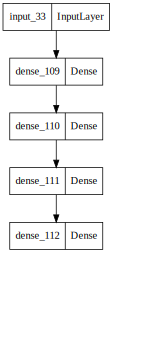

In [121]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(m).create(prog='dot', format='svg'))

**Question.** Compiler et entraîner votre modèle avec le nombre d'epochs=15, l'ensemble de validation=25% et  batch size=40. Vous pouvez utiliser Adam comme optimiseur. A vous de choisir une fonction et métrique de perte adéaquates  pour ce type de problème. Réflichissez!

In [122]:
# Normalisons les données
mean = X_train_bis.mean(axis=0)
std = X_train_bis.std(axis=0)

X_train_bis = X_train_bis - mean
X_train_bis = X_train_bis / std

X_test_bis = X_test_bis - mean
X_test_bis = X_test_bis / std

In [123]:
#apprentissage
m.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
h3 = m.fit(X_train_bis, y_train_bis, epochs=15, batch_size=40, verbose =1, validation_split=0.25)

Epoch 1/15
3/3 [==============================] - 1s 111ms/step - loss: 1.0934 - acc: 0.3889 - val_loss: 0.9614 - val_acc: 0.8333
Epoch 2/15
3/3 [==============================] - 0s 19ms/step - loss: 0.9514 - acc: 0.8111 - val_loss: 0.8431 - val_acc: 0.9000
Epoch 3/15
3/3 [==============================] - 0s 21ms/step - loss: 0.8413 - acc: 0.8111 - val_loss: 0.7392 - val_acc: 0.9000
Epoch 4/15
3/3 [==============================] - 0s 19ms/step - loss: 0.7418 - acc: 0.8222 - val_loss: 0.6451 - val_acc: 0.9000
Epoch 5/15
3/3 [==============================] - 0s 22ms/step - loss: 0.6541 - acc: 0.8222 - val_loss: 0.5636 - val_acc: 0.9000
Epoch 6/15
3/3 [==============================] - 0s 19ms/step - loss: 0.5798 - acc: 0.8222 - val_loss: 0.4924 - val_acc: 0.9333
Epoch 7/15
3/3 [==============================] - 0s 19ms/step - loss: 0.5168 - acc: 0.8222 - val_loss: 0.4316 - val_acc: 0.9333
Epoch 8/15
3/3 [==============================] - 0s 23ms/step - loss: 0.4642 - acc: 0.8222 - va

**Question.** Tracez les courbes d'apprentissage (train_loss et val_loss)

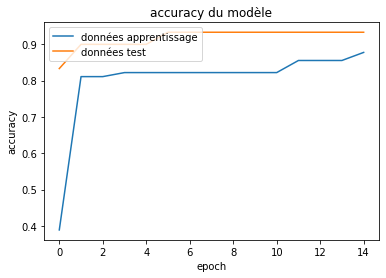

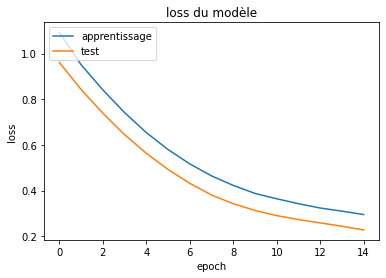

In [124]:
affiche_evolution_apprentissage(h3)

**Question.** Interpréter le résultat obtenu. Que constatez-vous ? 

### Si l'accuracy sur les données d'apprentissage est moins bon que sur les données de test. On est dans une situation du sous-apprentissage. Si c'est l'inverse, on est dans une situation de sur-apprentissage. Attention, les graphiques dépendent du code d'entrainement précédent (model.fit(...)) car on aura pas les mêmes ensembles d'apprentissage et les mêmes ensembles de test à cause du paramètre validation_split

**Question.** Après avoir construit le modèle, utiliser la commande  EarlyStopping() sans paramètres sous Keras pour éviter le problème d'Overfitting. Re-entraîner le modèle.

In [125]:
from keras.callbacks import EarlyStopping
es = EarlyStopping()
h3_es= m.fit(X_train_bis, y_train_bis,
                    epochs=15,
                    batch_size=40,
                    verbose =1,
                    validation_split=0.25,
                    callbacks=[es])

Epoch 1/15
3/3 [==============================] - 0s 39ms/step - loss: 0.2810 - acc: 0.8667 - val_loss: 0.2176 - val_acc: 0.9000
Epoch 2/15
3/3 [==============================] - 0s 20ms/step - loss: 0.2696 - acc: 0.8667 - val_loss: 0.2130 - val_acc: 0.9000


**Question.**  Interpréter le résulat

### on constate que l'entrainement s'est interrompu une fois que la métrique (ici accuracy) a cessé de s'améliorer pendant un nombre fixe d'époques, c'est-à-dire que EarlyStopping a permis d'interrompre l'entrainement dès que le modèle à commencer à sur-ajuster, évitant ainsi d'avoir à relancer l'entrainement du modèle avec un plus petit nombre d'époques.

**Question.** Re-tracez les courbes d'apprentissage (train_loss et val_loss)

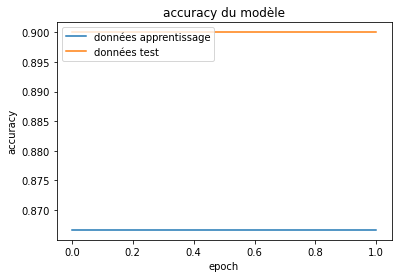

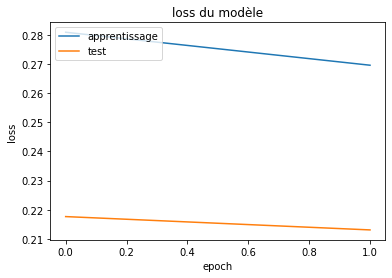

In [126]:
affiche_evolution_apprentissage(h3_es)

**Question.**  Interpréter le résulat des courbes d'apprentissage obtenus

### En abscisse, on a le nombre d'époques quand EarlyStopping a interrompu l'entrainement. Ensuite, les valeurs d'accuracy en données d'apprentissage et en données de test pour chaque époque sont représentées. De même, pour les valeurs de la fonction de perte.

**Question.** Après avoir essayer EarlyStopping() sans paramètres, personaliser maintenant cette commande en fixant les les paramètres min_delta=$1e-3$, patience=8 et mode='max'.


In [127]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(min_delta=0.001, patience=8, verbose=1, mode='max')

**Question.** Expliquer les paramètres suivants: min_delta, patience et verbose.

### min_delta : si la différence entre deux valeurs de la métrique calculée est inférieure à min_delta, alors on considère que la métrique ne s'est pas améliorée.

### patience : nombre d'époques au delà duquel l'entrainement peut s'interrompre quand la métrique a cessé de s'améliorer

### verbose : c'est soit 0 (n'affiche pas d'information pendant l'entrainement) , soit 1 (affiche les informations pendant l'entrainement)

**Question.** Entraîner votre modèle en tenant en compte l'instruction d'EarlySopping personalisé.

In [128]:
es = EarlyStopping(min_delta=0.001, patience=8, verbose=1, mode='max')
h3_es= m.fit(X_train_bis, y_train_bis,
                    epochs=15,
                    batch_size=40,
                    verbose = 1,
                    validation_split=0.25,
                    callbacks=[es])

Epoch 1/15
3/3 [==============================] - 0s 40ms/step - loss: 0.2732 - acc: 0.8444 - val_loss: 0.2121 - val_acc: 0.9000
Epoch 2/15
3/3 [==============================] - 0s 22ms/step - loss: 0.2650 - acc: 0.8444 - val_loss: 0.1990 - val_acc: 0.9000
Epoch 3/15
3/3 [==============================] - 0s 19ms/step - loss: 0.2489 - acc: 0.8667 - val_loss: 0.1885 - val_acc: 0.9000
Epoch 4/15
3/3 [==============================] - 0s 19ms/step - loss: 0.2357 - acc: 0.9111 - val_loss: 0.1832 - val_acc: 0.9333
Epoch 5/15
3/3 [==============================] - 0s 20ms/step - loss: 0.2270 - acc: 0.9222 - val_loss: 0.1736 - val_acc: 0.9667
Epoch 6/15
3/3 [==============================] - 0s 21ms/step - loss: 0.2195 - acc: 0.9111 - val_loss: 0.1599 - val_acc: 0.9667
Epoch 7/15
3/3 [==============================] - 0s 19ms/step - loss: 0.2093 - acc: 0.9444 - val_loss: 0.1484 - val_acc: 0.9667
Epoch 8/15
3/3 [==============================] - 0s 22ms/step - loss: 0.2001 - acc: 0.9333 - val

**Question.** Interpréter le résultat

### Comme verbose égal 1, on peut lire les informations. Selon les ensembles d'apprentissage, et les ensembles de validation, on n'a ou pas d'overfiting. Si on a overfitiging, le dernier époque d'entrainement correspond à l'époque au dessus duquel le model commence à sur-ajuster, et donc EarlyStopping arrête l'entrainement. 

**Question.** Tracez les courbes d'apprentissage (train_loss et val_loss)

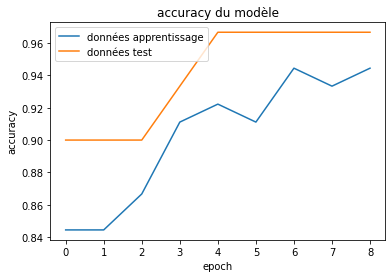

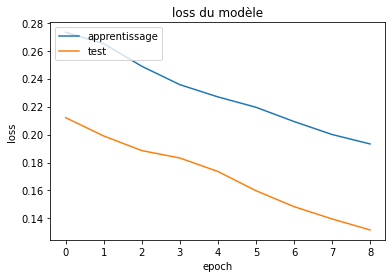

In [129]:
affiche_evolution_apprentissage(h3_es)

**Question.** Que constatez-vous ?

### En abscisse, on a le nombre d'époques quand EarlyStopping a interrompu l'entrainement. Ensuite, les valeurs d'accuracy en données d'apprentissage et en données de test pour chaque époque sont représentées. De même, pour les valeurs de la fonction de perte.

## Régression avec EarlyStopping

Après avoir apprendre un modèle de classification, maintenant on s'intéresse à un problème de régression. 

En utilisant Pandas, nous allons charger le fichier CSV des données auto à partir de cette URL: "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv". Dans la même instruction, nous vérifiions s'il y a des valeurs manquantes comme 'NA' ou '?' et les stocker dans une variable nommée na_values.

In [130]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import pandas as pd
import numpy as np
from sklearn import metrics

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv", 
    na_values=['NA', '?'])

cars = df['name']

# Gérer les valeurs manquantes
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

In [131]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


**Question.** Convertir les données en Numpy pour faire la régression (données x et y)

In [132]:
X = df[df.columns[1:8]] # variables cylinders jusqu'à origin
X = X.to_numpy()

Y = df[df.columns[0]] # variable mpg
Y = Y.to_numpy()

**Question.** Découper les données en ensembles de training et test avec la taille de test=25%

In [133]:
from sklearn.model_selection import train_test_split
X_train_bis, X_test_bis, y_train_bis, y_test_bis = train_test_split(X, Y, test_size=0.25, shuffle=True)

**Question.** Constuire un modèle de réseau de neurones séquentiel contenant 2 couches cachées (25, 10). Attention: Il faut choisir la métrique de perte la plus adéquate! Vous pouvez utiliser ADAM comme l'exercice précédent.

In [134]:
#réseau complet
entree= Input(shape=(7,)) # X_train_bis.shape[1] = 7
cachee_1= Dense(25, activation='relu')(entree)
cachee_2 = Dense(10, activation='relu')(cachee_1)
sortie = Dense(1)(cachee_2)
m = Model(entree, sortie)

m.compile(loss='mse',          # fonction de perte
              optimizer='adam', # optimiseur
              metrics=['mae'])  # métrique

In [135]:
m.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_113 (Dense)           (None, 25)                200       
                                                                 
 dense_114 (Dense)           (None, 10)                260       
                                                                 
 dense_115 (Dense)           (None, 1)                 11        
                                                                 
Total params: 471
Trainable params: 471
Non-trainable params: 0
_________________________________________________________________


**Question.** Entraîner maintenant le modèle avec un nombre d'epochs=300. Vous ajouterez la méthode EarlyStopping() avec min delta=$1e-3$, patience=5 et mode='auto'. Afficher et commenter les résultats obtenus.

In [136]:
# Normalisons les données
mean = X_train_bis.mean(axis=0)
std = X_train_bis.std(axis=0)

X_train_bis = X_train_bis - mean
X_train_bis = X_train_bis / std

X_test_bis = X_test_bis - mean
X_test_bis = X_test_bis / std

In [137]:
# Apprentissage
es = EarlyStopping(min_delta=0.001, patience=5, verbose=1, mode='auto')
h = m.fit(X_train_bis, y_train_bis,
                    epochs=300,
                    batch_size=40,
                    verbose = 1,
                    validation_split=0.25,
                    callbacks=[es])

Epoch 1/300
6/6 [==============================] - 1s 37ms/step - loss: 578.2657 - mae: 22.7988 - val_loss: 703.9714 - val_mae: 25.2031
Epoch 2/300
6/6 [==============================] - 0s 11ms/step - loss: 572.1356 - mae: 22.6633 - val_loss: 697.5034 - val_mae: 25.0737
Epoch 3/300
6/6 [==============================] - 0s 11ms/step - loss: 566.2702 - mae: 22.5309 - val_loss: 691.2349 - val_mae: 24.9460
Epoch 4/300
6/6 [==============================] - 0s 12ms/step - loss: 560.5001 - mae: 22.3987 - val_loss: 684.9142 - val_mae: 24.8168
Epoch 5/300
6/6 [==============================] - 0s 9ms/step - loss: 554.7059 - mae: 22.2650 - val_loss: 678.6223 - val_mae: 24.6873
Epoch 6/300
6/6 [==============================] - 0s 9ms/step - loss: 548.9913 - mae: 22.1314 - val_loss: 672.0964 - val_mae: 24.5534
Epoch 7/300
6/6 [==============================] - 0s 9ms/step - loss: 543.0897 - mae: 21.9955 - val_loss: 665.4014 - val_mae: 24.4149
Epoch 8/300
6/6 [==============================] - 

### Comme verbose égal 1, on peut lire les informations. Selon les ensembles d'apprentissage, et les ensembles de validation, on n'a ou pas d'overfiting. Si on a overfitiging, le dernier époque d'entrainement correspond à l'époque au dessus duquel le model commence à sur-ajuster, et donc EarlyStopping arrête l'entrainement.

In [138]:
def affiche_evolution_apprentissage_regression(history):
    #affiche history.history.keys()
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('erreur absolue moyenne du modèle')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['données apprentissage', 'données test'], loc='upper left')
    plt.show()
    # résumé de l'historique pour loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss du modèle')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['apprentissage', 'test'], loc='upper left')
    plt.show()

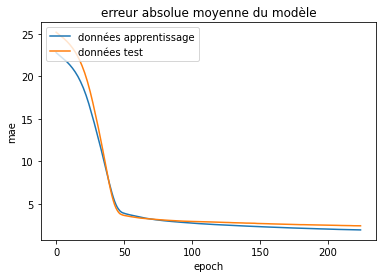

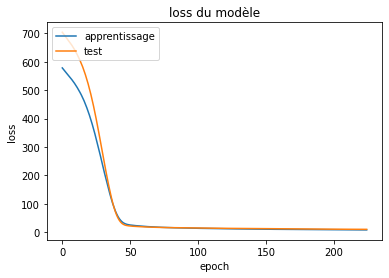

In [139]:
affiche_evolution_apprentissage_regression(h)

In [140]:
# score d'évaluation
loss_score, mae_score = m.evaluate(X_test_bis, y_test_bis)
print("loss score :",loss_score)
print(" mae_score :", mae_score)

4/4 [==============================] - 0s 3ms/step - loss: 9.9252 - mae: 2.1173
loss score : 9.925158500671387
 mae_score : 2.1173317432403564
